In [1]:
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
from models import Net

net=Net()
print(net)

Net(
  (conv1): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(68, 136, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(136, 272, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=183872, out_features=1000, bias=True)
  (fc_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=136, bias=True)
)


In [3]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset

from data_load import Rescale, RandomCrop, Normalize, ToTensor

In [4]:
data_transform=transforms.Compose([Rescale(250),
                                   RandomCrop(224),
                                   Normalize(),
                                   ToTensor()])
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
transformed_dataset=FacialKeypointsDataset(csv_file=r"C:\Users\rahul\OneDrive\P1_Facial_Keypoints-master\data\training_frames_keypoints.csv",
                                           root_dir=r"C:\Users\rahul\OneDrive\P1_Facial_Keypoints-master\data\training", 
                                           transform=data_transform)
print("Number of images: ", len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample=transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [6]:
batch_size=10

train_loader=DataLoader(transformed_dataset, 
                        batch_size=batch_size,
                        shuffle=True)

# Before Training, our test images results:

In [7]:
test_dataset=FacialKeypointsDataset(csv_file=r"C:\Users\rahul\OneDrive\P1_Facial_Keypoints-master\data\test_frames_keypoints.csv",
                                    root_dir=r"C:\Users\rahul\OneDrive\P1_Facial_Keypoints-master\data\test",
                                    transform=data_transform)

In [8]:
batch_size=10

test_loader=DataLoader(test_dataset,
                       batch_size=batch_size,
                       shuffle=True)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
#Testing model on a batch of images

def net_sample_output():
    
    #Iterate through test data
    for i, sample in enumerate(test_loader):
        
        #get sample data: image and ground truth keypoints
        images=sample['image']
        key_pts=sample['keypoints']
        
        images=images.type(torch.FloatTensor)
        
        output_pts=net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts=output_pts.view(output_pts.size()[0], 68, -1)
        
        #break after first image is tested:
        if i==0:
            return images, output_pts, key_pts        

In [11]:
test_images, test_outputs, gt_pts=net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    #images here are grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

# Un-transformation

Next, you'll see a helper function. *visualize_output* that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors and it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.


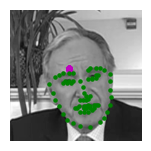

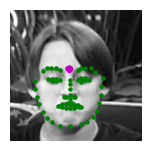

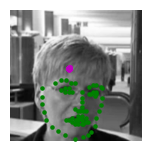

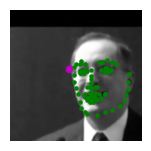

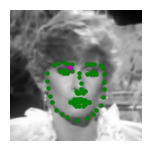

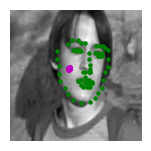

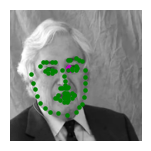

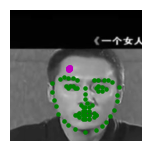

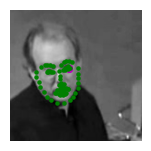

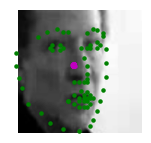

In [13]:
def visualize_output(test_images, test_outputs, get_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax=plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data
        image=test_images[i].data
        image=image.numpy()
        image=np.transpose(image, (1,2,0))
        
        # un-transform the predicted key_pts data
        predicted_key_pts=test_outputs[i].data
        predicted_key_pts=predicted_key_pts.numpy()
        predicted_key_pts=predicted_key_pts*50.0 + 100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts=None
        
        if gt_pts is not None:
            ground_truth_pts=gt_pts[i]
            ground_truth_pts=ground_truth_pts*50.0 +100
        
        #calling the function show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        
        plt.axis('off')
        
    plt.show()

#call this function now
visualize_output(test_images, test_outputs, gt_pts)
        

In [14]:
import torch.optim as optim

criteria=nn.MSELoss()

optimizer=optim.Adam(net.parameters(), lr=0.001)

In [15]:
def train_net(n_epochs):
    #prepare net for training
    net.train()
    
    for epoch in range(n_epochs):
        
        running_loss=0.0
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            
            # get the input images and their corresponding labels
            images=data['image']
            key_pts=data['keypoints']
            
            #flatten pts
            key_pts=key_pts.view(key_pts.size(0), -1)
            
            #convert variables to float for regression loss
            key_pts=key_pts.type(torch.FloatTensor)
            images=images.type(torch.FloatTensor)
            
            #forward pass to get outputs
            output_pts=net(images)
            
            #calculating loss between predicted and target keypoints
            loss=criteria(output_pts, key_pts)
            
            #zero the parameter(weight) gradients
            optimizer.zero_grad()
            
            #backward pass to calculate weight gradients
            loss.backward()
            
            #update the weights
            optimizer.step()
            
            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss+=loss.item()
            if (batch_i%10==9):
                print("Epoch: {}, Batch: {}, Avg. Loss: {}".format(epoch+1, batch_i+1, running_loss/1000))
                running_loss=0
    print("Finished Training!")

In [16]:
# train your network
n_epochs = 1 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.009825167536735535
Epoch: 1, Batch: 20, Avg. Loss: 0.0025240036696195602
Epoch: 1, Batch: 30, Avg. Loss: 0.0026360297203063964
Epoch: 1, Batch: 40, Avg. Loss: 0.002270652249455452
Epoch: 1, Batch: 50, Avg. Loss: 0.0021594392955303194
Epoch: 1, Batch: 60, Avg. Loss: 0.0018920106887817382
Epoch: 1, Batch: 70, Avg. Loss: 0.0022572960406541825
Epoch: 1, Batch: 80, Avg. Loss: 0.002138470187783241
Epoch: 1, Batch: 90, Avg. Loss: 0.0020902371928095817
Epoch: 1, Batch: 100, Avg. Loss: 0.0019374202713370323
Epoch: 1, Batch: 110, Avg. Loss: 0.0020775944367051125
Epoch: 1, Batch: 120, Avg. Loss: 0.001831865444779396
Epoch: 1, Batch: 130, Avg. Loss: 0.0034433343112468717
Epoch: 1, Batch: 140, Avg. Loss: 0.002229972280561924
Epoch: 1, Batch: 150, Avg. Loss: 0.0024597142487764356
Epoch: 1, Batch: 160, Avg. Loss: 0.0026069004982709884
Epoch: 1, Batch: 170, Avg. Loss: 0.001974907748401165
Epoch: 1, Batch: 180, Avg. Loss: 0.0017081156373023986
Epoch: 1, Batch: 190, Avg

# Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [19]:
# get sample of test data again
test_images, test_outputs, gt_pts=net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


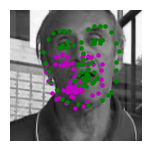

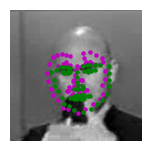

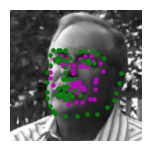

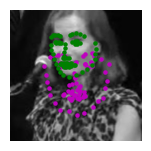

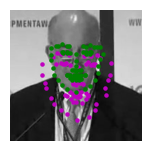

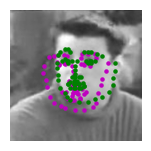

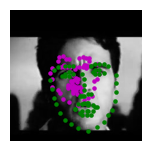

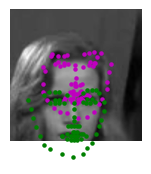

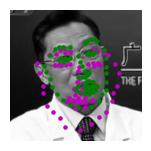

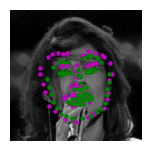

In [20]:
visualize_output(test_images, test_outputs, gt_pts)

In [22]:
model_dir=r'C:\Users\rahul\computer vision\Project\saved_models\CNN'
model_name='keypoints_detection_model.py'

torch.save(net.state_dict(), model_dir+model_name)